# **BBP ASR**

### Model Loading

In [ ]:
# %%capture
# !pip install datasets
!pip install transformers
!pip install torchaudio ipywebrtc notebook
!pip install pydub
# !pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow
import os
import librosa
import numpy as np
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
from numpy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.spatial import distance
from matplotlib import rcParamsDefault
from pydub import AudioSegment

import pandas as pd
import json
import matplotlib.patches as mpatches

In [13]:
PATH_TO_VOCAB_FILE = "./neurological_dataset_all_types_plus_TTS_set3/vocab.json"
PATH_TO_WEIGHTS_FOLDER = "./neurological_dataset_all_types_plus_TTS_set3/checkpoint-4850/"

# sample audio file (to be replaced by the audio recorded on alphawit front-end)
SPEECH_FILE = './NF00_10_01_BBP_NORMAL.wav'

In [59]:
%%writefile helper.py
class ASRLoader:
    def __init__(self, PATH_TO_VOCAB_FILE, PATH_TO_WEIGHTS_FOLDER):
        self.PATH_TO_VOCAB_FILE = PATH_TO_VOCAB_FILE
        self.PATH_TO_WEIGHTS_FOLDER = PATH_TO_WEIGHTS_FOLDER
        self.SPEECH_FILE = SPEECH_FILE

    # function that loads the ML model
    def load_model(self):
      tokenizer = Wav2Vec2CTCTokenizer(self.PATH_TO_VOCAB_FILE, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
      feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
      processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
      model = Wav2Vec2ForCTC.from_pretrained(self.PATH_TO_WEIGHTS_FOLDER).cuda()
      return model, processor, feature_extractor

    # apply ML model to transcribe audio
    # you would just use the audio recorded in front-end as the input
    def apply_ml(self, SPEECH_FILE):
      file_Sample, sr = librosa.load(SPEECH_FILE)
      file_Sample = librosa.resample(file_Sample, orig_sr=sr, target_sr=16000)
      inputs = feature_extractor(file_Sample, sampling_rate=16000, return_tensors="pt")
      inputs.to('cuda')
      with torch.no_grad():
          logits = model(**inputs).logits
      predicted_class_ids = torch.argmax(logits, dim=-1)
      predicted_asr = processor.batch_decode(predicted_class_ids)[0]
      # each repetition has to have one of 3 words in it, so we count all 3 words occurences and take the max as # of repetitions
      buy_oc = predicted_asr.count('buy')
      bobby_oc = predicted_asr.count('bobby')
      puppy_oc = predicted_asr.count('puppy')
      counts_num_min = min(buy_oc, bobby_oc, puppy_oc)
      counts_num_max = max(buy_oc, bobby_oc, puppy_oc)
      # counts_num_max
      transcription = processor.batch_decode(predicted_class_ids)[0]
      return counts_num_max, transcription

Writing helper.py


In [11]:
asr_loader = ASRLoader(PATH_TO_VOCAB_FILE, PATH_TO_WEIGHTS_FOLDER)
model, processor, feature_extractor = asr_loader.load_model()

### Analyze Model

In [14]:
counts_num_max, transcription = asr_loader.apply_ml(SPEECH_FILE)

### DTW Alignment

In [17]:
### IoU Calculator
class AudioParser:
  """Audio Parser class that utilizes DTW to parse new signals based on parsed reference file.
    Parameters
    ----------
    x: Array
      output audio array from librosa.load (reference)
    fs1: int
      sampling frequency output from librosa.load (reference)
    fs2: int
      sampling frequency output from librosa.load (audio file to be parsed)
    start_lst: list
        reference parsings for start of each repetition
    end_lst: list
        reference parsings for end of each repetition
    path: list of tuples
        DTW warping path
    path: int - default = 512
        hop size of MFCC
    """
  def __init__(self, fs1, fs2, reference_txt_path, target_txt_path=None, path=None, hop_size=512):
    self.reference_text_path = reference_txt_path
    self.target_txt_path = target_txt_path
    self.path = path
    self.hop_size = hop_size
    self.fs1 = fs1
    self.fs2 = fs2
    # setting threshold
    self.THRESH = 0.75

  def time_to_position_converter(self, time):
    # total duration of audio file
    # dur = librosa.get_duration(self.x, sr=self.fs1)
    # get position of time in audio array
    position_audio = round(time*self.fs1)
    # map position into mfcc array
    position_mfcc = round(position_audio/self.hop_size)
    return position_mfcc

  def position_to_time_converter(self, position_mfcc):
    position_audio = position_mfcc*self.hop_size
    time = position_audio / self.fs2
    return time

  def start_end_list_generator(self):
    start_lst = []
    end_lst = []
    f = open(self.reference_text_path, 'r')
    for line in f:
        if ('rep' in line.lower() or 'bbp' in line.lower()):
            a = line.split(',')
            start_lst.append(float(a[0]))
            end_lst.append(float(a[2]))
    return start_lst, end_lst

  def start_end_list_generator_target(self):
    start_lst = []
    end_lst = []
    start_lst_new = []
    end_lst_new = []
    with open(self.target_txt_path, 'r') as f:
      data = json.load(f)
    start_lst = data['BBP_parsed'][0]
    end_lst = data['BBP_parsed'][1]
    for i in range (0, len(start_lst), 4):
      start_lst_new.append(start_lst[i])
    for i in range (3, len(end_lst), 4):
      end_lst_new.append(end_lst[i])
    return start_lst_new, end_lst_new
  
  def audio_parser(self):
    start_lst_parsed_temp = []
    end_lst_parsed_temp = []
    start_lst_parsed = []
    end_lst_parsed = []
    start_lst, end_lst = self.start_end_list_generator()
    for i,j in zip(start_lst, end_lst):
      t_start = self.time_to_position_converter(i)
      t_end = self.time_to_position_converter(j)
      for k in self.path:
        if k[0] == t_start:
          start_lst_parsed_temp.append(self.position_to_time_converter(k[1]))
        elif k[0] == t_end:
          end_lst_parsed_temp.append(self.position_to_time_converter(k[1]))
      if start_lst_parsed_temp:
        start_lst_parsed.append(start_lst_parsed_temp[len(start_lst_parsed_temp)-1])
      if end_lst_parsed_temp:
        end_lst_parsed.append(end_lst_parsed_temp[len(end_lst_parsed_temp)-1])
      start_lst_parsed_temp = []
      end_lst_parsed_temp = []
    return start_lst_parsed, end_lst_parsed
    
  def bbp_speech_duration_generator_target(self):
    lst_dur_BBP = []
    start_lst, end_lst = self.audio_parser()
    for i in range(len(start_lst)):
      lst_dur_BBP.append(end_lst[i] - start_lst[i])
    return lst_dur_BBP
  
  def bbp_speech_duration_generator_target_value(self):
    lst_dur_BBP = []
    start_lst, end_lst = self.final_parser()
    for i in range(len(start_lst)):
      lst_dur_BBP.append(end_lst[i] - start_lst[i])
    return sum(lst_dur_BBP)
  
  def bbp_total_duration_generator_target(self):
    start_lst, end_lst = self.final_parser()
    return end_lst[len(end_lst)-1] - start_lst[0]
  
  def bbp_pause_duration_generator_target(self):
    total_duration = self.bbp_total_duration_generator_target()
    speech_duration = self.bbp_speech_duration_generator_target_value()
    return total_duration - speech_duration

  def outlier_detector(self):
    lst_dur_BBP = self.bbp_speech_duration_generator_target()
    if len(lst_dur_BBP) < 2:
      return 0
    else:
      lst_range = []
      lst_threshold_bbp = [i for i in range(len(lst_dur_BBP)) if lst_dur_BBP[i] < self.THRESH*np.mean(lst_dur_BBP)]
      for i in range(0, len(lst_threshold_bbp)-1):
        lst_range.append(np.abs(lst_threshold_bbp[i] - lst_threshold_bbp[i+1]))
      if 1 not in lst_range:
        return 0
      else:
        return lst_threshold_bbp, lst_range
  
  def parsing_aligner(self):
    if not self.outlier_detector():
      return 0
    start_lst_new, end_lst_new = self.audio_parser()
    lst_threshold_bbp, lst_range = self.outlier_detector()
    for i in reversed(range(len(lst_range))):
      if lst_range[i] == 1:
        idx = lst_threshold_bbp[i]
        start_lst_new.pop(idx + 1)
        end_lst_new.pop(idx)
    return start_lst_new, end_lst_new
  
  def final_parser(self):
    if self.parsing_aligner():
      return self.parsing_aligner()
    return self.audio_parser()

  def iou_calculator(self):
    import math
    start_lst, end_lst = self.start_end_list_generator()
    if not self.parsing_aligner():
      start_lst_new, end_lst_new = self.final_parser()
    else:
      start_lst_new, end_lst_new = self.parsing_aligner()
    iou_list = []
    for jik in range(0, min(len(start_lst), len(end_lst), len(start_lst_new), len(end_lst_new))):
        union_cal = (max(end_lst[jik], end_lst_new[jik]) - min(start_lst[jik], start_lst_new[jik]))
        intersection_cal = (min(end_lst[jik], end_lst_new[jik]) - max(start_lst[jik], start_lst_new[jik]))
        iou_list.append(abs(intersection_cal / union_cal)*100)
    return iou_list

In [34]:
class DTWImplementation:
    def __init__(self, dist):
        self.dist = dist
    # dtw algorithm based on drop-dtw paper
    def dtw_paper(self):
        "Classical DTW algorithm"

        nrows, ncols = self.dist.shape
        # nrows, ncols = len(dist1), len(dist2)
        dtw = np.zeros((nrows + 1,ncols + 1), dtype=np.float32)
        # get dtw table
        for i in range(0, nrows + 1):
            for j in range(0, ncols + 1):
                if (i == 0) and (j == 0):
                    new_val = 0.0
                    dtw[i, j] = new_val
                elif (i == 0) and (j != 0):
                    new_val = np.inf
                    dtw[i, j] = new_val
                elif (i != 0) and (j == 0):
                    new_val = np.inf
                    dtw[i, j] = new_val
                else:
                    neighbors = [dtw[i, j - 1], dtw[i - 1, j - 1], dtw[i - 1, j]]
                    new_val = self.dist[i - 1, j - 1] + min(neighbors)
                    dtw[i, j] = new_val
        # get alignment path
        path = self.traceback(dtw)
        return dtw, path

    def traceback(self, d):
        i, j = np.array(d.shape) - 2
        p, q = [i], [j]
        while (i > 0) or (j > 0):
            tb = np.argmin((d[i, j], d[i, j + 1], d[i + 1, j]))
            if tb == 0:
                i -= 1
                j -= 1
            elif tb == 1:
                i -= 1
            else:  # (tb == 2):
                j -= 1
            p.insert(0, i)
            q.insert(0, j)
        return np.array(p), np.array(q)

In [40]:
class AudioAligner:
    def __init__(self, SPEECH_FILE, counts_num_max, hop_size = 512):
        self.SPEECH_FILE = SPEECH_FILE
        self.counts_num_max = counts_num_max
        self.hop_size = hop_size

    def match_target_amplitude(self, sound, target_dBFS):
        change_in_dBFS = target_dBFS - sound.dBFS
        return sound.apply_gain(change_in_dBFS)

    def sequence_matching(self, X, Y, subseq=False):
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y)

        # Perform some shape-squashing here
        # Put the time axes around front
        X = np.swapaxes(X, -1, 0)
        Y = np.swapaxes(Y, -1, 0)

        # Flatten the remaining dimensions
        # Use F-ordering to preserve columns
        X = X.reshape((X.shape[0], -1), order="F")
        Y = Y.reshape((Y.shape[0], -1), order="F")

        try:
            C = distance.cdist(X, Y, metric="euclidean")
        except ValueError as exc:
            raise ParameterError(
                "scipy.spatial.distance.cdist returned an error.\n"
                "Please provide your input in the form X.shape=(K, N) "
                "and Y.shape=(K, M).\n 1-dimensional sequences should "
                "be reshaped to X.shape=(1, N) and Y.shape=(1, M)."
            ) from exc

        # for subsequence matching:
        # if N > M, Y can be a subsequence of X
        if subseq and (X.shape[0] > Y.shape[0]):
            C = C.T

        return C

    def audio_aligner(self):
        ref_audio = reference_audio_dict[counts_num_max]
        ref_parse = reference_parse_dict[counts_num_max]

        x_1, fs1 = librosa.load(ref_audio)
        x_2, fs2 = librosa.load(SPEECH_FILE)

        ref_audio = reference_audio_dict[counts_num_max]
        ref_parse = reference_parse_dict[counts_num_max]

        sound = AudioSegment.from_file(ref_audio, "wav")
        normalized_sound = self.match_target_amplitude(sound, -65.0)
        normalized_sound.export("ref_audio.wav", format="wav")

        sound_target = AudioSegment.from_file(SPEECH_FILE, "wav")
        normalized_sound_target = self.match_target_amplitude(sound_target, -65.0)
        normalized_sound_target.export("target_audio.wav", format="wav")

        x_1, fs1 = librosa.load("ref_audio.wav")
        x_2, fs2 = librosa.load("target_audio.wav")

        # make and display a mel-scaled power (energy-squared) spectrogram
        S1 = librosa.feature.melspectrogram(y=x_1, sr=fs1, n_mels=128)
        S2 = librosa.feature.melspectrogram(y=x_2, sr=fs2, n_mels=128)

        # Convert to log scale (dB). We'll use the peak power as reference.
        log_S1 = librosa.amplitude_to_db(S1)
        log_S2 = librosa.amplitude_to_db(S2)
        x_1_mfcc = librosa.feature.mfcc(S=log_S1, n_mfcc=13)
        x_2_mfcc = librosa.feature.mfcc(S=log_S2, n_mfcc=13)

        matrix_mfcc = self.sequence_matching(x_1_mfcc, x_2_mfcc)
        D, wp = DTWImplementation(matrix_mfcc).dtw_paper()
        wp = np.asarray(wp)
        wp = wp.T
        wp_s = np.asarray(wp) * self.hop_size / fs1

        return x_1, x_2, fs1, fs2, ref_parse, wp, wp_s

In [27]:
# Create a dictunary, repetition #: audio file path
reference_audio_dict = {
    1: "./reference_audio/1_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    2: "./reference_audio/2_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    3: "./reference_audio/3_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    4: "./reference_audio/4_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    5: "./reference_audio/5_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    6: "./reference_audio/6_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    7: "./reference_audio/7_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    8: "./reference_audio/8_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    9: "./reference_audio/9_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    10: "./reference_audio/10_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    11: "./reference_audio/11_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    12: "./reference_audio/12_NF01_02_SBK_20170515_BBP_NORMAL_al.wav",
    13: "./reference_audio/13_NF01_02_SBK_20170515_BBP_NORMAL_al.wav"
}

In [28]:
# Create a dictunary, repetition #: parsed file path
reference_parse_dict_whole = {
    1: "./reference_parse/1_NF01_02_BBP_NORMAL_audio.Table",
    2: "./reference_parse/2_NF01_02_BBP_NORMAL_audio.Table",
    3: "./reference_parse/3_NF01_02_BBP_NORMAL_audio.Table",
    4: "./reference_parse/4_NF01_02_BBP_NORMAL_audio.Table",
    5: "./reference_parse/5_NF01_02_BBP_NORMAL_audio.Table",
    6: "./reference_parse/6_NF01_02_BBP_NORMAL_audio.Table",
    7: "./reference_parse/7_NF01_02_BBP_NORMAL_audio.Table",
    8: "./reference_parse/8_NF01_02_BBP_NORMAL_audio.Table",
    9: "./reference_parse/9_NF01_02_BBP_NORMAL_audio.Table",
    10: "./reference_parse/10_NF01_02_BBP_NORMAL_audio.Table",
    11: "./reference_parse/11_NF01_02_BBP_NORMAL_audio.Table",
    12: "./reference_parse/12_NF01_02_BBP_NORMAL_audio.Table",
    13: "./reference_parse/13_NF01_02_BBP_NORMAL_audio.Table"
}

In [29]:
# Create a dictunary, repetition #: parsed file path
reference_parse_dict = {
    1: "./reference_parse_word_precision/1_NF01_02_BBP_NORMAL_audio.Table",
    2: "./reference_parse_word_precision/2_NF01_02_BBP_NORMAL_audio.Table",
    3: "./reference_parse_word_precision/3_NF01_02_BBP_NORMAL_audio.Table",
    4: "./reference_parse_word_precision/4_NF01_02_BBP_NORMAL_audio.Table",
    5: "./reference_parse_word_precision/5_NF01_02_BBP_NORMAL_audio.Table",
    6: "./reference_parse_word_precision/6_NF01_02_BBP_NORMAL_audio.Table",
    7: "./reference_parse_word_precision/7_NF01_02_BBP_NORMAL_audio.Table",
    8: "./reference_parse_word_precision/8_NF01_02_BBP_NORMAL_audio.Table",
    9: "./reference_parse_word_precision/9_NF01_02_BBP_NORMAL_audio.Table",
    10: "./reference_parse_word_precision/10_NF01_02_BBP_NORMAL_audio.Table",
    11: "./reference_parse_word_precision/11_NF01_02_BBP_NORMAL_audio.Table",
    12: "./reference_parse_word_precision/12_NF01_02_BBP_NORMAL_audio.Table",
    13: "./reference_parse_word_precision/13_NF01_02_BBP_NORMAL_audio.Table"
}

In [41]:
x_1, x_2, fs1, fs2, ref_parse, wp, wp_s = AudioAligner(SPEECH_FILE, counts_num_max, hop_size = 512).audio_aligner()

In [43]:
obj = AudioParser(fs1, fs2, ref_parse, path=wp)

### DTW Alignment Result

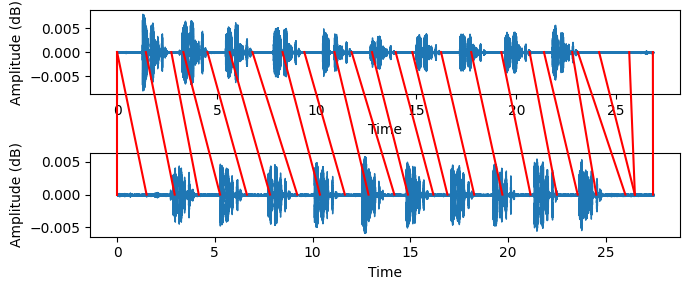

In [44]:
fig = plt.figure(figsize=(7, 3))

plt.rcParams.update(rcParamsDefault)
# Plot x_1
plt.subplot(2, 1, 1)
plt.ylabel("Amplitude (dB)")
librosa.display.waveshow(x_1, sr=fs1)
# plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveshow(x_2, sr=fs2)
# plt.title('Slower Version $X_2$')
ax2 = plt.gca()
plt.ylabel("Amplitude (dB)")
plt.tight_layout()


trans_figure = fig.transFigure.inverted()
lines = []
arrows = 25
points_idx = np.int16(np.round(np.linspace(0, wp_s.shape[0] - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp_s[points_idx]:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r')
    lines.append(line)

fig.lines = lines
plt.tight_layout()
# saving the plot
# plt.savefig('BBP_AF06_AF10_dtw_small.png', dpi = 300)
plt.show()

In [45]:
fig = plt.figure(figsize=(7, 2))
plt.xlabel("Time (s)")
librosa.display.waveshow(x_1[0:int(len(x_1)/9)], sr=fs1)
plt.show()
# plt.savefig('BBP_one_rep.png', dpi = 300)

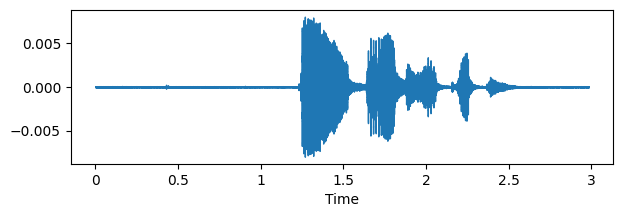

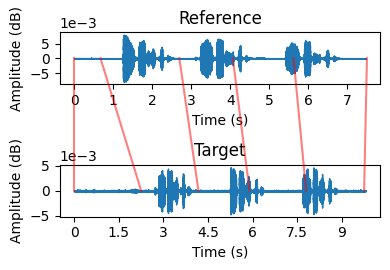

In [46]:
fig = plt.figure(figsize=(4, 2.8))
plt.rcParams.update(rcParamsDefault)
# Plot x_1
plt.subplot(2, 1, 1)
plt.ylabel("Amplitude (dB)")
plt.title('Reference')
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
librosa.display.waveshow(x_1[0:int(len(x_1)/3.6)], sr=fs1)
plt.xlabel("Time (s)")
# plt.title('Slower Version $X_1$')
ax1 = plt.gca()

# Plot x_2
plt.subplot(2, 1, 2)
librosa.display.waveshow(x_2[0:int(len(x_2)//2.8)], sr=fs2)
# plt.title('Slower Version $X_2$')
ax2 = plt.gca()
plt.ylabel("Amplitude (dB)")
plt.xlabel("Time (s)")
plt.title('Target')
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
plt.tight_layout()


trans_figure = fig.transFigure.inverted()
lines = []
arrows = 6
points_idx = np.int16(np.round(np.linspace(0, wp_s.shape[0]//3.2 - 1, arrows)))

# for tp1, tp2 in zip((wp[points_idx, 0]) * hop_size, (wp[points_idx, 1]) * hop_size):
for tp1, tp2 in wp_s[points_idx]:
    # get position on axis for a given index-pair
    coord1 = trans_figure.transform(ax1.transData.transform([tp1, 0]))
    coord2 = trans_figure.transform(ax2.transData.transform([tp2, 0]))

    # draw a line
    line = matplotlib.lines.Line2D((coord1[0], coord2[0]),
                                   (coord1[1], coord2[1]),
                                   transform=fig.transFigure,
                                   color='r',
                                   alpha = 0.5)
    lines.append(line)
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
fig.lines = lines
ax2.set_title('Target')
plt.tight_layout()
# saving the plot
# plt.savefig('BBP_AF06_AF10_dtw_small.png', dpi = 300)
plt.show()

In [47]:
wp_s.shape[0]

1561

In [48]:
x_1[0:len(x_1)//2]

array([-2.3308576e-07, -2.0201609e-05, -3.5865771e-05, ...,
       -1.1823983e-04, -1.2480092e-04, -1.2012437e-04], dtype=float32)

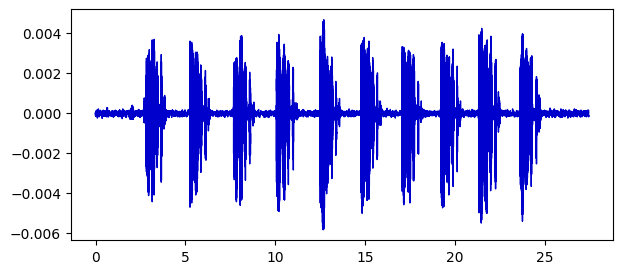

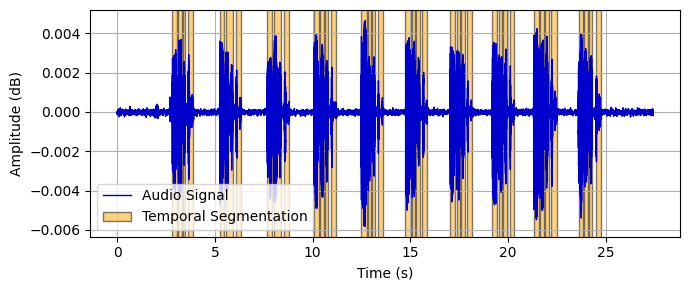

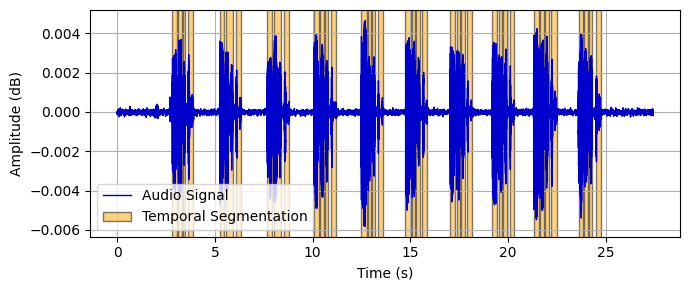

In [51]:
# Interpretation method for comparing parsing of repnet and landmark based for paper
# csfont = {'fontname':'Times New Roman',
#          'size'   : 15}
# csfont2 = {'fontname':'Times New Roman',
#          'size'   : 15}
# plt.rcParams.update({'font.size': 10})
plt.rcParams.update(rcParamsDefault)
plt.figure(figsize=(7, 3))
# plt.xlim(0 * 10, len(x_1)/fs1 * 10)

# import wave
# # reading the audio file
# raw = wave.open("bbp_audio/AF02_02_SBK_20170517_BBP_NORMAL.wav")
#
# # reads all the frames
# # -1 indicates all or max frames
# signal = raw.readframes(-1)
# signal = np.frombuffer(signal, dtype ="int16")
#
# # gets the frame rate
# f_rate = raw.getframerate()

# to Plot the x-axis in seconds
# you need get the frame rate
# and divide by size of your signal
# to create a Time Vector
# spaced linearly with the size
# of the audio file
time = np.linspace(
    0, # start
    len(x_2) / fs2,
    num = len(x_2)
)
plt.plot(time, x_2, label="Audio Signal", linewidth=1, color="mediumblue")
# plt.yticks(np.arange(-0.004, 0.004, step=0.002))
plt.xticks(np.arange(0, librosa.get_duration(y=x_2, sr=fs2), 5))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dB)")
ax = plt.gca()

parsed_start, parsed_end = obj.final_parser()
for i in range(0, len(parsed_start)):
    left_forced, bottom_forced, width_forced, height_forced = (parsed_start[i], -0.05, parsed_end[i]-parsed_start[i], 0.1)
    if i == 0:
        rect_forced=mpatches.Rectangle((left_forced,bottom_forced),width_forced,height_forced,
                            fill=True,
                            alpha=0.5,
                            facecolor="orange",
                            edgecolor = "black",
                            label="Temporal Segmentation",
                            linewidth=1)
                            #facecolor="green")
        plt.gca().add_patch(rect_forced)
    else:
        rect_forced=mpatches.Rectangle((left_forced,bottom_forced),width_forced,height_forced,
                            fill=True,
                            alpha=0.5,
                            facecolor="orange",
                            edgecolor = "black",
                            linewidth=1)
                            #facecolor="green")
        plt.gca().add_patch(rect_forced)

plt.legend()
# plt.title("Visual Comparison of Parsing Methods for BBP", **csfont)
# saving the plot
plt.tight_layout()
plt.show()
# plt.savefig('BBP_AF06_AF10_dtw_small_parsed.png', dpi = 300)


# end of test

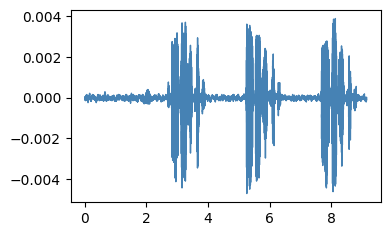

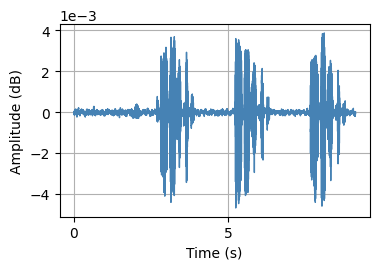

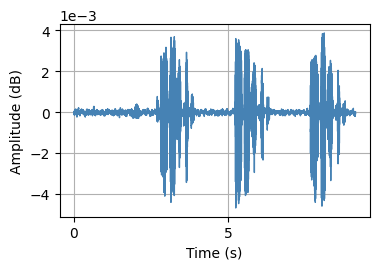

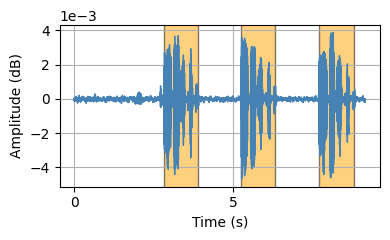

In [58]:
# Interpretation method for comparing parsing of repnet and landmark based for paper
# csfont = {'fontname':'Times New Roman',
#          'size'   : 15}
# csfont2 = {'fontname':'Times New Roman',
#          'size'   : 15}
# plt.rcParams.update({'font.size': 10})
plt.rcParams.update(rcParamsDefault)
plt.figure(figsize=(4, 2.5))
# plt.xlim(0 * 10, len(x_1)/fs1 * 10)

# import wave
# # reading the audio file
# raw = wave.open("bbp_audio/AF02_02_SBK_20170517_BBP_NORMAL.wav")
#
# # reads all the frames
# # -1 indicates all or max frames
# signal = raw.readframes(-1)
# signal = np.frombuffer(signal, dtype ="int16")
#
# # gets the frame rate
# f_rate = raw.getframerate()

# to Plot the x-axis in seconds
# you need get the frame rate
# and divide by size of your signal
# to create a Time Vector
# spaced linearly with the size
# of the audio file
time = np.linspace(
    0, # start
    int(len(x_2)//3) / fs2,
    num = int(len(x_2)//3)
)
plt.plot(time, x_2[0:int(len(x_2)//3)], label="Audio Signal", linewidth=1, color="steelblue")
# plt.yticks(np.arange(-0.004, 0.004, step=0.002))
plt.xticks(np.arange(0, librosa.get_duration(y=x_2[0:int(len(x_2)//3)], sr=fs2), 5))
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dB)")
ax = plt.gca()

parsed_start, parsed_end = obj.final_parser()
for i in range(3):
    left_forced, bottom_forced, width_forced, height_forced = (parsed_start_new[i], -0.05, parsed_end_new[i]-parsed_start_new[i], 0.1)
    if i == -1:
        rect_forced=mpatches.Rectangle((left_forced,bottom_forced),width_forced,height_forced,
                            fill=True,
                            alpha=0.5,
                            facecolor="white",
                            edgecolor = "black",
                            label="Temporal Segmentation",
                            linewidth=1)
                            #facecolor="green")
        plt.gca().add_patch(rect_forced)
    else:
        rect_forced=mpatches.Rectangle((left_forced,bottom_forced),width_forced,height_forced,
                            fill=True,
                            alpha=0.5,
                            facecolor="orange",
                            edgecolor = "black",
                            linewidth=1)
                            #facecolor="green")
        plt.gca().add_patch(rect_forced)

# plt.legend()
# plt.title("Visual Comparison of Parsing Methods for BBP", **csfont)
# saving the plot
plt.tight_layout()
plt.show()
# plt.savefig('BBP_AF06_AF10_dtw_small_parsed.png', dpi = 300)


# end of test

In [55]:
parsed_start_new = []
parsed_start_new.append(parsed_start[0])
parsed_start_new.append(parsed_start[4])
parsed_start_new.append(parsed_start[7])

In [57]:
parsed_end_new = []
parsed_end_new.append(parsed_end[3])
parsed_end_new.append(parsed_end[6])
parsed_end_new.append(parsed_end[9])

In [ ]:
parsed_start_new

[2.809614512471655, 5.2477097505668935, 7.685804988662132]

In [ ]:
parsed_end_new

[3.900952380952381, 6.315827664399093, 8.800362811791382]

In [54]:
print("Transcription: ", transcription)
print("Total Number of Repetitions: ", counts_num_max)
print("Total Duration: ", obj.bbp_total_duration_generator_target())
print("Speech Duration: ", obj.bbp_speech_duration_generator_target_value())
print("Pause Duration: ", obj.bbp_pause_duration_generator_target())
# speaking rate: total # of words spoken / total duration * 60 (since speaking rate is # of words spoken in 60 seconds)
print("Speaking Rate: ", len(obj.final_parser()[0])*60/obj.bbp_total_duration_generator_target())

Transcription:  py buy boby a puppy buy boby a puppy buy boby a puppy buy boby a puppy buy boby a puppy buy boby a puppy buy boby a puppy buy boby a puppy buy boby a puppy buy boby a pupy a puppy
Total Number of Repetitions:  10
Total Duration:  21.96607709750567
Speech Duration:  8.893242630385489
Pause Duration:  13.072834467120183
Speaking Rate:  103.79641252642705
